In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
%matplotlib inline
from bs4 import BeautifulSoup
import urllib
import re
from scipy.stats import mode
from datetime import timedelta
from math import modf
from sklearn.preprocessing import PolynomialFeatures

sns.set()

pd.set_option('display.max_rows', 450)  # показывать больше строк
pd.set_option('display.max_columns', 150)  # показывать больше колонок

Выгружаем датасет в переменную df

In [17]:
df = pd.read_csv('main_task.csv')

Смотрим на количество пропусков в данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


Распарсим данные с сайта для столбца диапазона цен

In [4]:
def fill_price_range(row):

    if pd.isnull(row['Price Range']):
        try:
            url = 'https://www.tripadvisor.ru' + row['URL_TA']
            html_doc = urllib.request.urlopen(url).read()
            soup = BeautifulSoup(html_doc)
        except:
            row['Price Range'] = 'no data'
            return row

        try:
            parsed_html = str(soup.find_all('div', '_1ud-0ITN')[0])
            pattern = re.compile('[$]{1,3}\s?-?\s?[$]*')
            text = re.findall(pattern, parsed_html)
        except:
            pass
        try:
            row['Price Range'] = text[0]
        except:
            row['Price Range'] = 'no data'

    return row


df = df.apply(fill_price_range, axis=1)

id_0
id_0
id_1
id_2
id_3
id_4
id_5
id_6
id_7
id_8
id_9
id_10
id_11
id_12
id_13
id_14
id_15
id_16
id_17
id_18
id_19
id_20
id_21
id_22
id_23
id_24
id_25
id_26
id_27
id_28
id_29
id_30
id_31
id_32
id_33
id_34
id_35
id_36
id_37
id_38
id_39
id_40
id_41
id_42
id_43
id_44
id_45
id_46
id_47
id_48
id_49
id_50
id_51
id_52
id_53
id_54
id_55
id_56
id_57
id_58
id_59
id_60
id_61
id_62
id_63
id_64
id_65
id_66
id_67
id_68
id_69
id_70
id_71
id_72
id_73
id_74
id_75
id_76
id_77
id_78
id_79
id_80
id_81
id_82
id_83
id_84
id_85
id_86
id_87
id_88
id_89
id_90
id_91
id_92
id_93
id_94
id_95
id_96
id_97
id_98
id_99
id_100
id_101
id_102
id_103
id_104
id_105
id_106
id_107
id_108
id_109
id_110
id_111
id_112
id_113
id_114
id_115
id_116
id_117
id_118
id_119
id_120
id_121
id_122
id_123
id_124
id_125
id_126
id_127
id_128
id_129
id_130
id_131
id_132
id_133
id_134
id_135
id_136
id_137
id_138
id_139
id_140
id_141
id_142
id_143
id_144
id_145
id_146
id_147
id_148
id_149
id_150
id_151
id_152
id_153
id_154
id_155
id_156
id_157

id_1163
id_1164
id_1165
id_1166
id_1167
id_1168
id_1169
id_1170
id_1171
id_1172
id_1173
id_1174
id_1175
id_1176
id_1177
id_1178
id_1179
id_1180
id_1181
id_1182
id_1183
id_1184
id_1185
id_1186
id_1187
id_1188
id_1189
id_1190
id_1191
id_1192
id_1193
id_1194
id_1195
id_1196
id_1197
id_1198
id_1199
id_1200
id_1201
id_1202
id_1203
id_1204
id_1205
id_1206
id_1207
id_1208
id_1209
id_1210
id_1211
id_1212
id_1213
id_1214
id_1215
id_1216
id_1217
id_1218
id_1219
id_1220
id_1221
id_1222
id_1223
id_1224
id_1225
id_1226
id_1227
id_1228
id_1229
id_1230
id_1231
id_1232
id_1233
id_1234
id_1235
id_1236
id_1237
id_1238
id_1239
id_1240
id_1241
id_1242
id_1243
id_1244
id_1245
id_1246
id_1247
id_1248
id_1249
id_1250
id_1251
id_1252
id_1253
id_1254
id_1255
id_1256
id_1257
id_1258
id_1259
id_1260
id_1261
id_1262
id_1263
id_1264
id_1265
id_1266
id_1267
id_1268
id_1269
id_1270
id_1271
id_1272
id_1273
id_1274
id_1275
id_1276
id_1277
id_1278
id_1279
id_1280
id_1281
id_1282
id_1283
id_1284
id_1285
id_1286
id_1287


id_2189
id_2190
id_2191
id_2192
id_2193
id_2194
id_2195
id_2196
id_2197
id_2198
id_2199
id_2200
id_2201
id_2202
id_2203
id_2204
id_2205
id_2206
id_2207
id_2208
id_2209
id_2210
id_2211
id_2212
id_2213
id_2214
id_2215
id_2216
id_2217
id_2218
id_2219
id_2220
id_2221
id_2222
id_2223
id_2224
id_2225
id_2226
id_2227
id_2228
id_2229
id_2230
id_2231
id_2232
id_2233
id_2234
id_2235
id_2236
id_2237
id_2238
id_2239
id_2240
id_2241
id_2242
id_2243
id_2244
id_2245
id_2246
id_2247
id_2248
id_2249
id_2250
id_2251
id_2252
id_2253
id_2254
id_2255
id_2256
id_2257
id_2258
id_2259
id_2260
id_2261
id_2262
id_2263
id_2264
id_2265
id_2266
id_2267
id_2268
id_2269
id_2270
id_2271
id_2272
id_2273
id_2274
id_2275
id_2276
id_2277
id_2278
id_2279
id_2280
id_2281
id_2282
id_2283
id_2284
id_2285
id_2286
id_2287
id_2288
id_2289
id_2290
id_2291
id_2292
id_2293
id_2294
id_2295
id_2296
id_2297
id_2298
id_2299
id_2300
id_2301
id_2302
id_2303
id_2304
id_2305
id_2306
id_2307
id_2308
id_2309
id_2310
id_2311
id_2312
id_2313


id_3214
id_3215
id_3216
id_3217
id_3218
id_3219
id_3220
id_3221
id_3222
id_3223
id_3224
id_3225
id_3226
id_3227
id_3228
id_3229
id_3230
id_3231
id_3232
id_3233
id_3234
id_3235
id_3236
id_3237
id_3238
id_3239
id_3240
id_3241
id_3242
id_3243
id_3244
id_3245
id_3246
id_3247
id_3248
id_3249
id_3250
id_3251
id_3252
id_3253
id_3254
id_3255
id_3256
id_3257
id_3258
id_3259
id_3260
id_3261
id_3262
id_3263
id_3264
id_3265
id_3266
id_3267
id_3268
id_3269
id_3270
id_3271
id_3272
id_3273
id_3274
id_3275
id_3276
id_3277
id_3278
id_3279
id_3280
id_3281
id_3282
id_3283
id_3284
id_3285
id_3286
id_3287
id_3288
id_3289
id_3290
id_3291
id_3292
id_3293
id_3294
id_3295
id_3296
id_3297
id_3298
id_3299
id_3300
id_3301
id_3302
id_3303
id_3304
id_3305
id_3306
id_3307
id_3308
id_3309
id_3310
id_3311
id_3312
id_3313
id_3314
id_3315
id_3316
id_3317
id_3318
id_3319
id_3320
id_3321
id_3322
id_3323
id_3324
id_3325
id_3326
id_3327
id_3328
id_3329
id_3330
id_3331
id_3332
id_3333
id_3334
id_3335
id_3336
id_3337
id_3338


id_4243
id_4244
id_4245
id_4246
id_4247
id_4248
id_4249
id_4250
id_4251
id_4252
id_4253
id_4254
id_4255
id_4256
id_4257
id_4258
id_4259
id_4260
id_4261
id_4262
id_4263
id_4264
id_4265
id_4266
id_4267
id_4268
id_4269
id_4270
id_4271
id_4272
id_4273
id_4274
id_4275
id_4276
id_4277
id_4278
id_4279
id_4280
id_4281
id_4282
id_4283
id_4284
id_4285
id_4286
id_4287
id_4288
id_4289
id_4290
id_4291
id_4292
id_4293
id_4294
id_4295
id_4296
id_4297
id_4298
id_4299
id_4300
id_4301
id_4302
id_4303
id_4304
id_4305
id_4306
id_4307
id_4308
id_4309
id_4310
id_4311
id_4312
id_4313
id_4314
id_4315
id_4316
id_4317
id_4318
id_4319
id_4320
id_4321
id_4322
id_4323
id_4324
id_4325
id_4326
id_4327
id_4328
id_4329
id_4330
id_4331
id_4332
id_4333
id_4334
id_4335
id_4336
id_4337
id_4338
id_4339
id_4340
id_4341
id_4342
id_4343
id_4344
id_4345
id_4346
id_4347
id_4348
id_4349
id_4350
id_4351
id_4352
id_4353
id_4354
id_4355
id_4356
id_4357
id_4358
id_4359
id_4360
id_4361
id_4362
id_4363
id_4364
id_4365
id_4366
id_4367


id_5272
id_5273
id_5274
id_5275
id_5276
id_5277
id_5278
id_5279
id_5280
id_5281
id_5282
id_5283
id_5284
id_5285
id_5286
id_5287
id_5288
id_5289
id_5290
id_5291
id_5292
id_5293
id_5294
id_5295
id_5296
id_5297
id_5298
id_5299
id_5300
id_5301
id_5302
id_5303
id_5304
id_5305
id_5306
id_5307
id_5308
id_5309
id_5310
id_5311
id_5312
id_5313
id_5314
id_5315
id_5316
id_5317
id_5318
id_5319
id_5320
id_5321
id_5322
id_5323
id_5324
id_5325
id_5326
id_5327
id_5328
id_5329
id_5330
id_5331
id_5332
id_5333
id_5334
id_5335
id_5336
id_5337
id_5338
id_5339
id_5340
id_5341
id_5342
id_5343
id_5344
id_5345
id_5346
id_5347
id_5348
id_5349
id_5350
id_5351
id_5352
id_5353
id_5354
id_5355
id_5356
id_5357
id_5358
id_5359
id_5360
id_5361
id_5362
id_5363
id_5364
id_5365
id_5366
id_5367
id_5368
id_5369
id_5370
id_5371
id_5372
id_5373
id_5374
id_5375
id_5376
id_5377
id_5378
id_5379
id_5380
id_5381
id_5382
id_5383
id_5384
id_5385
id_5386
id_5387
id_5388
id_5389
id_5390
id_5391
id_5392
id_5393
id_5394
id_5395
id_5396


id_6297
id_6298
id_6299
id_6300
id_6301
id_6302
id_6303
id_6304
id_6305
id_6306
id_6307
id_6308
id_6309
id_6310
id_6311
id_6312
id_6313
id_6314
id_6315
id_6316
id_6317
id_6318
id_6319
id_6320
id_6321
id_6322
id_6323
id_6324
id_6325
id_6326
id_6327
id_6328
id_6329
id_6330
id_6331
id_6332
id_6333
id_6334
id_6335
id_6336
id_6337
id_6338
id_6339
id_6340
id_6341
id_6342
id_6343
id_6344
id_6345
id_6346
id_6347
id_6348
id_6349
id_6350
id_6351
id_6352
id_6353
id_6354
id_6355
id_6356
id_6357
id_6358
id_6359
id_6360
id_6361
id_6362
id_6363
id_6364
id_6365
id_6366
id_6367
id_6368
id_6369
id_6370
id_6371
id_6372
id_6373
id_6374
id_6375
id_6376
id_6377
id_6378
id_6379
id_6380
id_6381
id_6382
id_6383
id_6384
id_6385
id_6386
id_6387
id_6388
id_6389
id_6390
id_6391
id_6392
id_6393
id_6394
id_6395
id_6396
id_6397
id_6398
id_6399
id_6400
id_6401
id_6402
id_6403
id_6404
id_6405
id_6406
id_6407
id_6408
id_6409
id_6410
id_6411
id_6412
id_6413
id_6414
id_6415
id_6416
id_6417
id_6418
id_6419
id_6420
id_6421


id_7323
id_7324
id_7325
id_7326
id_7327
id_7328
id_7329
id_7330
id_7331
id_7332
id_7333
id_7334
id_7335
id_7336
id_7337
id_7338
id_7339
id_7340
id_7341
id_7342
id_7343
id_7344
id_7345
id_7346
id_7347
id_7348
id_7349
id_7350
id_7351
id_7352
id_7353
id_7354
id_7355
id_7356
id_7357
id_7358
id_7359
id_7360
id_7361
id_7362
id_7363
id_7364
id_7365
id_7366
id_7367
id_7368
id_7369
id_7370
id_7371
id_7372
id_7373
id_7374
id_7375
id_7376
id_7377
id_7378
id_7379
id_7380
id_7381
id_7382
id_7383
id_7384
id_7385
id_7386
id_7387
id_7388
id_7389
id_7390
id_7391
id_7392
id_7393
id_7394
id_7395
id_7396
id_7397
id_7398
id_7399
id_7400
id_7401
id_7402
id_7403
id_7404
id_7405
id_7406
id_7407
id_7408
id_7409
id_7410
id_7411
id_7412
id_7413
id_7414
id_7415
id_7416
id_7417
id_7418
id_7419
id_7420
id_7421
id_7422
id_7423
id_7424
id_7425
id_7426
id_7427
id_7428
id_7429
id_7430
id_7431
id_7432
id_7433
id_7434
id_7435
id_7436
id_7437
id_7438
id_7439
id_7440
id_7441
id_7442
id_7443
id_7444
id_7445
id_7446
id_7447


id_8349
id_8350
id_8351
id_8352
id_8353
id_8354
id_8355
id_8356
id_8357
id_8358
id_8359
id_8360
id_8361
id_8362
id_8363
id_8364
id_8365
id_8366
id_8367
id_8368
id_8369
id_8370
id_8371
id_8372
id_8373
id_8374
id_8375
id_8376
id_8377
id_8378
id_8379
id_8380
id_8381
id_8382
id_8383
id_8384
id_8385
id_8386
id_8387
id_8388
id_8389
id_8390
id_8391
id_8392
id_8393
id_8394
id_8395
id_8396
id_8397
id_8398
id_8399
id_8400
id_8401
id_8402
id_8403
id_8404
id_8405
id_8406
id_8407
id_8408
id_8409
id_8410
id_8411
id_8412
id_8413
id_8414
id_8415
id_8416
id_8417
id_8418
id_8419
id_8420
id_8421
id_8422
id_8423
id_8424
id_8425
id_8426
id_8427
id_8428
id_8429
id_8430
id_8431
id_8432
id_8433
id_8434
id_8435
id_8436
id_8437
id_8438
id_8439
id_8440
id_8441
id_8442
id_8443
id_8444
id_8445
id_8446
id_8447
id_8448
id_8449
id_8450
id_8451
id_8452
id_8453
id_8454
id_8455
id_8456
id_8457
id_8458
id_8459
id_8460
id_8461
id_8462
id_8463
id_8464
id_8465
id_8466
id_8467
id_8468
id_8469
id_8470
id_8471
id_8472
id_8473


id_9376
id_9377
id_9378
id_9379
id_9380
id_9381
id_9382
id_9383
id_9384
id_9385
id_9386
id_9387
id_9388
id_9389
id_9390
id_9391
id_9392
id_9393
id_9394
id_9395
id_9396
id_9397
id_9398
id_9399
id_9400
id_9401
id_9402
id_9403
id_9404
id_9405
id_9406
id_9407
id_9408
id_9409
id_9410
id_9411
id_9412
id_9413
id_9414
id_9415
id_9416
id_9417
id_9418
id_9419
id_9420
id_9421
id_9422
id_9423
id_9424
id_9425
id_9426
id_9427
id_9428
id_9429
id_9430
id_9431
id_9432
id_9433
id_9434
id_9435
id_9436
id_9437
id_9438
id_9439
id_9440
id_9441
id_9442
id_9443
id_9444
id_9445
id_9446
id_9447
id_9448
id_9449
id_9450
id_9451
id_9452
id_9453
id_9454
id_9455
id_9456
id_9457
id_9458
id_9459
id_9460
id_9461
id_9462
id_9463
id_9464
id_9465
id_9466
id_9467
id_9468
id_9469
id_9470
id_9471
id_9472
id_9473
id_9474
id_9475
id_9476
id_9477
id_9478
id_9479
id_9480
id_9481
id_9482
id_9483
id_9484
id_9485
id_9486
id_9487
id_9488
id_9489
id_9490
id_9491
id_9492
id_9493
id_9494
id_9495
id_9496
id_9497
id_9498
id_9499
id_9500


In [4]:
def category_price_range(row):
    if row['Price Range'] == 'no data':
        row['Price Range'] = 0
    elif row['Price Range'] == '$$ - $$$':
        row['Price Range'] = 2
    elif row['Price Range'] == '$':
        row['Price Range'] = 1
    elif row['Price Range'] == '$$$$':
        row['Price Range'] = 3
    return row

In [5]:
df = df.apply(category_price_range, axis=1)
#df.to_csv('main_parsed_data.csv')

Чтобы каждый раз не парсить сайт, сохраняем частично заполненный датасет в файле main_parsed_data.csv

In [18]:
df = pd.read_csv('main_parsed_data.csv', index_col=0)

In [19]:
display(df.info())
display(df['Price Range'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        40000 non-null  int64  
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 3.4+ MB


None

2    22039
1     8961
0     7454
3     1546
Name: Price Range, dtype: int64

В результате парсинга удалось заполнить примерно половину всех значений

Возьмем с сайта информацию об общем количестве ресторанов по городам

In [6]:
cities = df.City.unique()

In [7]:
restaurant_number = {}
for city in cities:
    url = 'https://www.tripadvisor.ru' + df[df.City == city].URL_TA.iloc[0]
    html_doc = urllib.request.urlopen(url).read()
    soup = BeautifulSoup(html_doc)
    try:
        try:
            parsed_html = str(soup.find_all('div', '_3-W4EexF')[1])
        except:
            parsed_html = str(soup.find_all('div', '_3-W4EexF')[0])
    except:
        restaurant_number[city] = None
        continue
    pattern = re.compile('из \d*\s?\d*')
    text = re.findall(pattern, parsed_html)[0]
    pattern = re.compile('\d+')
    text = re.findall(pattern, text)
    text = int(''.join(text))
    restaurant_number[city] = text

Дозаполним ошибочную информацию с сайта вручную

In [8]:
restaurant_number['Amsterdam'] = 3625
restaurant_number['Budapest'] = 2720
restaurant_number['Lisbon'] = 4417
restaurant_number['Brussels'] = 2356

In [23]:
#df.to_csv('new_parsed_data.csv')

In [24]:
df = pd.read_csv('new_parsed_data.csv', index_col=0)

Так как городов всего 31, заполним вручную статистические показатели о населении городов

In [ ]:
city_information = {}
for city in cities:
    print(city)
    population_density = input('Введите данные о плотности населения:')
    population_number = input('Введите численность населения:')
    city_information[city] = [population_density, population_number]

Paris


Эту информацию также следует сохранить в файл, чтобы каждый раз не вводить значения вручную

In [ ]:
#city_information.to_csv('city_information.csv')

In [9]:
city_information = pd.read_csv('city_information.csv', index_col=0)

Перенесем информацию в датасет

In [10]:
df.loc[:, 'Population Density'] = 0
df.loc[:, 'Population Number'] = 0


def create_population_features(row):
    row['Population Density'] = city_information.loc[row['City'],
                                                     'population_density']
    row['Population Number'] = city_information.loc[row['City'],
                                                    'population_number']
    return row


df = df.apply(create_population_features, axis=1)

Нормализуем столбец численности населения в городах и приравняем слишком большие значения к единице

In [11]:
max_population_number = df['Population Number'][
    df['Population Number'] < df['Population Number'].max()].max()


def normalize_number_of_population(row):
    global max_population_number
    row['Population Number'] = row['Population Number'] / max_population_number
    if row['Population Number'] > 1:
        row['Population Number'] = 1
    return row


df = df.apply(normalize_number_of_population, axis=1)

Эти же манипуляции проделываем и со столбцом плотности начеления

In [12]:
max_population_density = df['Population Density'][
    df['Population Density'] < df['Population Density'].max()].max()


def normalize_density_of_population(row):
    global max_population_density
    row['Population Density'] = row[
        'Population Density'] / max_population_density
    if row['Population Density'] > 1:
        row['Population Density'] = 1
    return row


df = df.apply(normalize_density_of_population, axis=1)

Сделаем из строкового столбца стилей кухни Dummy-переменные

In [13]:
Cuisine_Style = df['Cuisine Style'].str.slice(1, -1)

Cuisine_Style = Cuisine_Style.fillna("'Other'")

Cuisine_Style = pd.DataFrame(
    Cuisine_Style.str.split(', ').tolist()).stack().reset_index()

Cuisine_Style.columns = ['row_index', 'row_subindex', 'style']

Cuisine_Style['style'] = Cuisine_Style['style'].str.slice(1, -1)

popular_styles = Cuisine_Style['style'].value_counts()[
    Cuisine_Style['style'].value_counts() > 1500].index

df['Cuisine Style'] = df['Cuisine Style'].fillna("Empty")

for style in popular_styles:
    df.loc[:, style] = 0


def fill_styles(row):
    other_identifier = 1
    for style in popular_styles:
        if style in row['Cuisine Style']:
            row[style] = 1
            other_identifier = 0
        if other_identifier == 1:
            row['Other'] = 1
    return row


df = df.apply(fill_styles, axis=1)

Заполним исходный столбец стилей кухни количеством стилей или пустым значением в случае пропусков

In [14]:
def transform_cuisine_style(row):
    if row['Cuisine Style'] != 'Empty':
        row['Cuisine Style'] = len(row['Cuisine Style'][1:-1].split(', '))
    else:
        row['Cuisine Style'] = np.nan

    return row


df = df.apply(transform_cuisine_style, axis=1)

Создаем библиотеку часто встречающихся положительных слов о ресторане

In [15]:
good_words = [
    'good', 'best', 'not bad', 'great', 'unique', 'nice', 'better', 'friendly',
    'amazing', 'excellent', 'clean', 'highly', 'high', 'quick', 'super',
    'wonderful', 'well', 'decent', 'tasty', 'beautiful', 'fantastic', 'ok'
]

Ищем количество положительных слов в столбце комментариев о ресторане, в случае отсутствия заполняем пустым значением

In [17]:
df.loc[:, 'Good Reviews'] = 0


def fill_good_reviews(row):
    global good_words
    count = 0
    if row['Reviews'] == '[[], []]':
        row['Reviews'] = np.nan
        return row
    for word in good_words:
        pattern = re.compile(r'\b{}\b'.format(word))
        result = re.findall(pattern, row['Reviews'].lower())
        count += len(result)
    row['Good Reviews'] = count
    return row


df = df.apply(fill_good_reviews, axis=1)

Создаем столбец категории популярности ресторана на основе данных о количестве отзывов

In [18]:
df.loc[:, 'Popular Category'] = 0


def ordinary_reviews_number(row):
    if row['Number of Reviews'] <= 7:
        row['Popular Category'] = 1
    elif row['Number of Reviews'] > 7 and row['Number of Reviews'] <= 20:
        row['Popular Category'] = 2
    elif row['Number of Reviews'] > 20 and row['Number of Reviews'] <= 53:
        row['Popular Category'] = 3
    elif row['Number of Reviews'] > 53 and row['Number of Reviews'] <= 153:
        row['Popular Category'] = 4
    elif row['Number of Reviews'] > 153:
        row['Popular Category'] = 5
    return row


df = df.apply(ordinary_reviews_number, axis=1)

Нормализуем столбец количества отзывов, приравнивая очень большие значения к единице

In [19]:
threshold_reviews_number = np.quantile(df['Number of Reviews'].dropna(), 0.995)

max_reviews_number = df[df['Number of Reviews'] <
                        threshold_reviews_number]['Number of Reviews'].max()


def normalize_number_of_reviews(row):
    global mean_reviews
    row['Number of Reviews'] = row['Number of Reviews'] / max_reviews_number
    if row['Number of Reviews'] > 1:
        row['Number of Reviews'] = 1

    return row


df = df.apply(normalize_number_of_reviews, axis=1)

Создаем столбец отношения рейтинга ресторана по городу к общему количеству ресторанов и нормализуем этот столбец 

In [20]:
df.loc[:, 'Ranking Category'] = None


def ranking_category(row):
    coef = row.Ranking / restaurant_number[row.City]
    if coef > 1:
        row['Ranking Category'] = 1
    row['Ranking Category'] = coef

    return row

In [22]:
df = df.apply(ranking_category, axis=1)

Создаем полиномиальный признак из количества отзывов и категории популярности, который в результате немного улучшит показатели итоговой модели

In [27]:
pf = PolynomialFeatures(2)
poly_features = pf.fit_transform(
    df.dropna()[['Number of Reviews', 'Popular Category']])

In [28]:
poly_features = pd.DataFrame(poly_features).iloc[:, 3]
poly_features = pd.DataFrame(poly_features)
poly_features.columns = ['PolyFeature']
df = pd.concat([df.dropna().reset_index(), poly_features], axis=1)

Из столбца города создаем Dummy-переменные

In [29]:
dummy = pd.get_dummies(df.City)
dummy = dummy.astype('int64')
df = pd.concat([df, dummy], axis=1)

Создаем столбец промежутка времени между двумя отзывами на сайте ресторана, в случае отрицательных значений берем модуль

In [30]:
df.loc[:, 'Reviews Timedelta'] = 0


def get_review_timedelta(row):
    pattern = re.compile(r'\d{2}/\d{2}/\d{4}')
    dates = re.findall(pattern, row['Reviews'])
    try:
        row['Reviews Timedelta'] = (pd.to_datetime(dates[0]) -
                                    pd.to_datetime(dates[1])).days

    except:
        row['Reviews Timedelta'] = np.nan

    return row


df = df.apply(get_review_timedelta, axis=1)
df['Reviews Timedelta'] = abs(df['Reviews Timedelta'])

Смотрим на распределение отношения рейтинга ресторана по городу к общему количеству ресторанов в городе и выбираем пороговое значение, которое в нормализованном столбце будет равно единице, как и значения изначально большие 

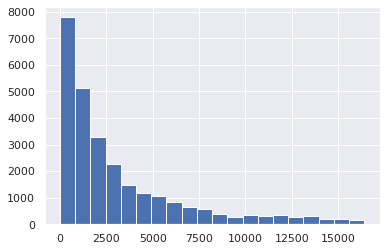

In [42]:
df['Ranking'].hist(bins=20)

In [31]:
treshhold_ranking = 7500


def normalize_ranking(row):
    row['Ranking'] = row['Ranking'] / treshhold_ranking
    if row['Ranking'] > 1:
        row['Ranking'] = 1
    return row


df = df.apply(normalize_ranking, axis=1)

Тестируем данные на модели случайного леса, избавляясь от ненужных столбцов и пустых значений, для большей точности проводим тест 10 раз и берем среднее.

Финальная версия датафрейма

In [107]:
df_train = pd.read_csv('final_version.csv', index_col=0)

Наилучшим решением оказалось убрать все строки с пустыми значениями, и строки, где категория диапазона цен равна 0. Именно после таких манипуляций с данными получался наилучший результат. Также я пробовал уменьшить количество Dummy-переменных для городов, но это также не оправдало ожидания.

In [104]:
test = df_train.copy()
test = test.drop(['Restaurant_id', 'City', 'Reviews', 'URL_TA', 'ID_TA'],
                 axis=1)
test = test.dropna()

X = test.drop(['Rating'], axis=1)
y = test['Rating']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

from sklearn.ensemble import RandomForestRegressor  # инструмент для создания и обучения модели
from sklearn import metrics  # инструменты для оценки точности модели

regr = RandomForestRegressor(n_estimators=100)

regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
res = metrics.mean_absolute_error(y_test, y_pred)
print('MAE:', res)

MAE: 0.20524169184290028


В результате проделанной работы показатель метрики MAE уменьшился с 0.5 до 0.2, в результате парсинга сайта TripAdvisor удалось заполнить часть пропусков, а также добавить новые признаки. На основе изначальных признаков также удалось сделать новые, нормализовать их и заменить слишком большие значения. Добавлено 2 dummy-переменных и один полиномиальный признак. С очень большой частью данных пришлось расстаться из-за пропусков, потому что ни один из основных методов их заполнения не принес успех в работе модели.